## Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df=pd.read_csv('/kaggle/input/iris/Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#inspecting number of rows and columns
df.shape

(150, 6)

## EDA

In [5]:
#checking for null values
df.isna().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

**Outlier Treatment**

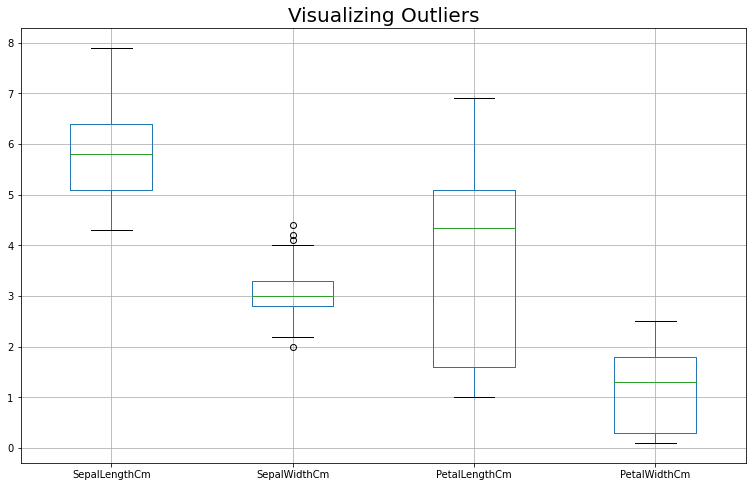

In [6]:
df.drop('Id',axis=1).boxplot(figsize=(13,8))
plt.title('Visualizing Outliers',fontdict={'fontsize':20})
plt.show()

The column 'SepalWidthCm' has some outliers,hence they should be removed.

In [7]:
q1=df['SepalWidthCm'].quantile(0.25)
q3=df['SepalWidthCm'].quantile(0.75)
iqr=q3-q1
ul=q3+1.5*iqr
ll=q1-1.5*iqr
df1=df[~((df['SepalWidthCm']<ll) | (df['SepalWidthCm']>ul))]

In [8]:
df1.shape

(146, 6)

In [9]:
df1.skew()

Id              -0.044923
SepalLengthCm    0.278417
SepalWidthCm     0.140812
PetalLengthCm   -0.323649
PetalWidthCm    -0.148777
dtype: float64

In [10]:
df1=df1.drop('Id',axis=1)

 Most of the columns are near normal distribution,hence no transformation required here.

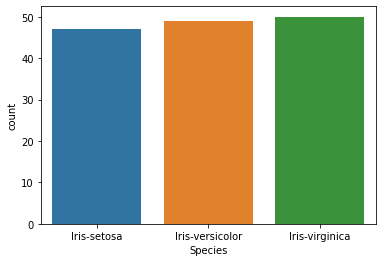

In [11]:
sns.countplot(df1['Species'])
plt.show()

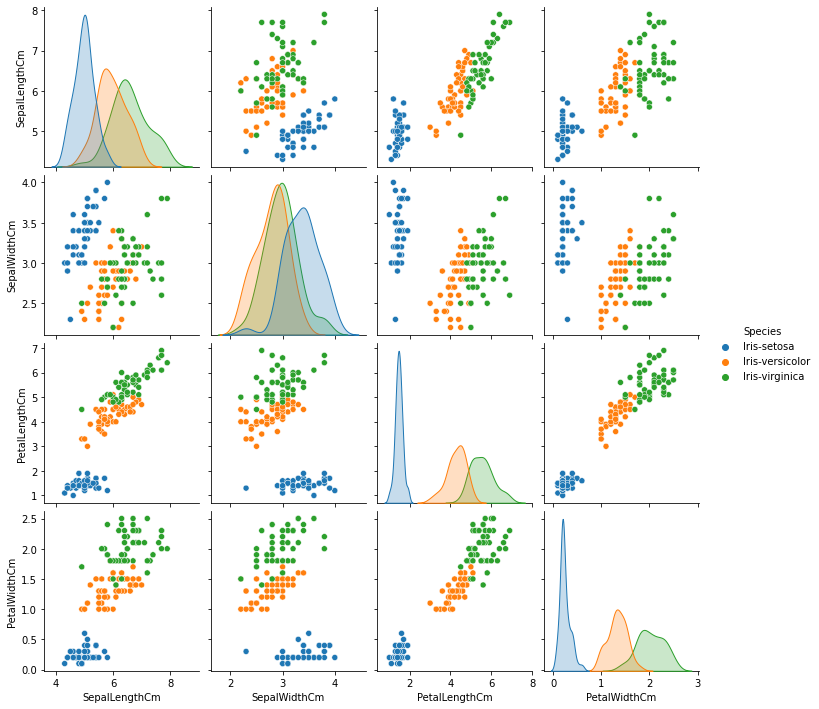

In [12]:
sns.pairplot(df1,hue='Species')

Looking at the pairplot,
* *For all the features we can easily classify 'Iris-Setosa'*
* *However the other two species on the other hand,overlaps with each other which might make classification dificult especially for 'SepalWidth' and 'SepalLength'.*


## Feature Scaling

In [13]:
x=df1.drop('Species',axis=1)
y=df1['Species']

In [14]:
ss=StandardScaler()
x_scaled=pd.DataFrame(ss.fit_transform(x),columns=x.columns)

In [15]:
x_scaled.head(2)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.910515,1.175789,-1.374878,-1.345899
1,-1.151122,-0.093924,-1.374878,-1.345899


## Model Building

In [16]:
X_train,X_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.3,shuffle=True,random_state=2)

In [17]:
kn4=KNeighborsClassifier(n_neighbors=4)#initializing knn model with '4' neigbors

In [18]:
kn4_model=kn4.fit(X_train,y_train)#fitting the model

In [19]:
print('Training Score:',kn4_model.score(X_train,y_train))

Training Score: 0.9313725490196079


In [20]:
print('Testing Score:',kn4_model.score(X_test,y_test))

Testing Score: 0.9318181818181818


**Thus the knn model with '4' neighbors is 93.2% sucessful in classifying the species of a plant.**

In [21]:
#predicting test_data
test_pred=kn4_model.predict(X_test)

In [22]:
print(classification_report(y_test,test_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.82      1.00      0.90        14
 Iris-virginica       1.00      0.80      0.89        15

       accuracy                           0.93        44
      macro avg       0.94      0.93      0.93        44
   weighted avg       0.94      0.93      0.93        44



* The f1-score for the  species 'Iris-versicolor'  and 'Iris-virginica' are less than 'Iris-setosa' , hence the model is finding it **slightly difficult** to make classification between the two species.
* The precision for 'Iris-setosa' is 1 indicating the model perfectly predicts this particular species. 

<AxesSubplot:>

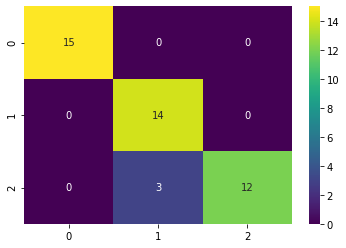

In [23]:
cfm=confusion_matrix(y_test,test_pred)
sns.heatmap(cfm,annot=True,cmap='viridis')

**From the above heatmap, it is clear that the model misclassified  three 'Iris-virginica' species as 'Iris-versicolor'**

## Grid Search CV

*Using GridSearchCV to find the best 'n_neighbors' for knn model*

In [24]:
param={'n_neighbors':np.arange(2,7)}#assigning n_neighbors from 2 to 6

In [25]:
knn=KNeighborsClassifier()

In [26]:
knngrid=GridSearchCV(knn,param_grid=param,scoring='f1_weighted',cv=5)

In [27]:
kgrid_model=knngrid.fit(X_train,y_train)

In [28]:
kgrid_model.best_params_

{'n_neighbors': 4}

*The best 'n_neighbors' acquired from GridSearchCV is 4,which is the one the model was built with.*

In [29]:
kgrid_model.best_score_

0.9111746031746032

## XGBoost Classifier

**To improve further accuracy lets try with 'XGB Classifier'**

In [30]:
xgb=XGBClassifier()

In [31]:
xgb_model=xgb.fit(X_train,y_train)

[07:40:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
print('Training Score:',xgb_model.score(X_train,y_train))

Training Score: 1.0


In [33]:
print('Testing Score:',xgb_model.score(X_test,y_test))

Testing Score: 1.0


In [34]:
xgb_pred=xgb_model.predict(X_test)

In [35]:
print(classification_report(y_test,xgb_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      1.00      1.00        14
 Iris-virginica       1.00      1.00      1.00        15

       accuracy                           1.00        44
      macro avg       1.00      1.00      1.00        44
   weighted avg       1.00      1.00      1.00        44



*f1-weighted score is 1 which means that our model has achieved 100% accuracy in predicting the species type.*

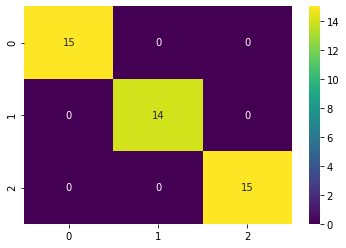

In [36]:
xgb_cf=confusion_matrix(y_test,xgb_pred)
sns.heatmap(xgb_cf,annot=True,cmap='viridis')
plt.show()

**The heatmap show that all the species from the test data have been classified with 100% accuracy**

In [37]:
k = KFold(n_splits=5,shuffle=True,random_state=48)
scores = cross_val_score(xgb,X_train,y_train,cv=k,scoring='f1_weighted')
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))


[07:40:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

**The bias and variance error is also very much low, meaning that there is no underfitting or overfitting problem with the model**